In [1]:
import numpy as np
import pandas as pd 
import glob

import networkx as nx
import matplotlib.pyplot as plt

# DATA FOLDER
DATA_FOLDER = "./data/"

The tutorial will focus on the paper _Abhijit Banerjee et al. ,The Diffusion of Microfinance. Science 341,1236498 (2013)_. In the paper, the authors explore the diffusion of information on micro-credit in several villages in India. In this tutorial, we will work with the original data from the paper, test some of the authors assumptions, and reproduce some of their results. 

In [ ]:
"""
    1. Load data on villages
"""

# Household info
info = ...
# Leaders-adopters
leadapt = ...

# Load network data
# Adjacency_matrix
adjmats = dict()
 
for file in sorted(glob.glob(DATA_FOLDER + "adjmat*.csv")):
    # find key adjmat 1 -> 0
    key = int(file.split("/")[-1].split(".")[0].strip("adjmat")) -1
    # load data as numpy array
    village_adj = np.loadtxt(file, delimiter=",")
    adjmats[key] = village_adj

graphs = ...

In [ ]:
"""
    1.1 Has everything worked? Plot a graph as an example.
"""

fig, ax = plt.subplots(figsize=(10, 10), dpi=200)

# Compute nodes positions using spring layout
pos = ...

...

plt.show()


In [ ]:
"""
    2. Are the villages similar? 
    Compute and plot a few basic statistics of our networks: number of nodes, number of edges, average degree, density, and number of components.
"""

n_nodes = np.zeros(len(graphs))
n_edges = np.zeros(len(graphs))
avg_degree = np.zeros(len(graphs))
density = np.zeros(len(graphs))
diameter = np.zeros(len(graphs))

...

# Plot distribution of number of nodes
...

# Plot distribution of density
...

In [ ]:
"""
    3. BSS, the microfinance institution mentioned in the paper, targeted "leaders" in the villages, assuming that they have a central role in the social network.
    Let's see if this is true.
"""

In [ ]:
"""
    Plot results
"""
# Make scatterplot of leaders vs non-leaders centrality
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter plot of degree centrality; blue circles
ax.scatter(
    avg_dc_leaders,
    avg_dc_nonleaders,
    color=niceblue,
    s=100,
    marker="o",
    facecolor="white",
    linewidths=2,
    label="Degree centrality",
)
# Scatter plot of betweenness centrality; red squares
ax.scatter(
    avg_bc_leaders,
    avg_bc_nonleaders,
    color=nicered,
    s=100,
    marker="s",
    facecolor="white",
    linewidths=2,
    label="Betweenness centrality",
)
# Scatter plot of closeness centrality; green triangles
ax.scatter(
    avg_cc_leaders,
    avg_cc_nonleaders,
    color=nicegreen,
    s=100,
    marker="^",
    facecolor="white",
    linewidths=2,
    label="Closeness centrality",
)

# Plot diagonal line
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

# Add legend
ax.legend(loc="upper left", fontsize=20)

# Add labels
ax.set_xlabel("Average centrality of leaders", fontsize=20)
ax.set_ylabel("Average centrality of non-leaders", fontsize=20)

plt.show()

In [ ]:
"""
    4. Assortative/disassortative mixing: do adopters and non-adopters connect more between themselves?
"""

In [ ]:
...

In [ ]:
# Now let's compute some random benchmarks!
...

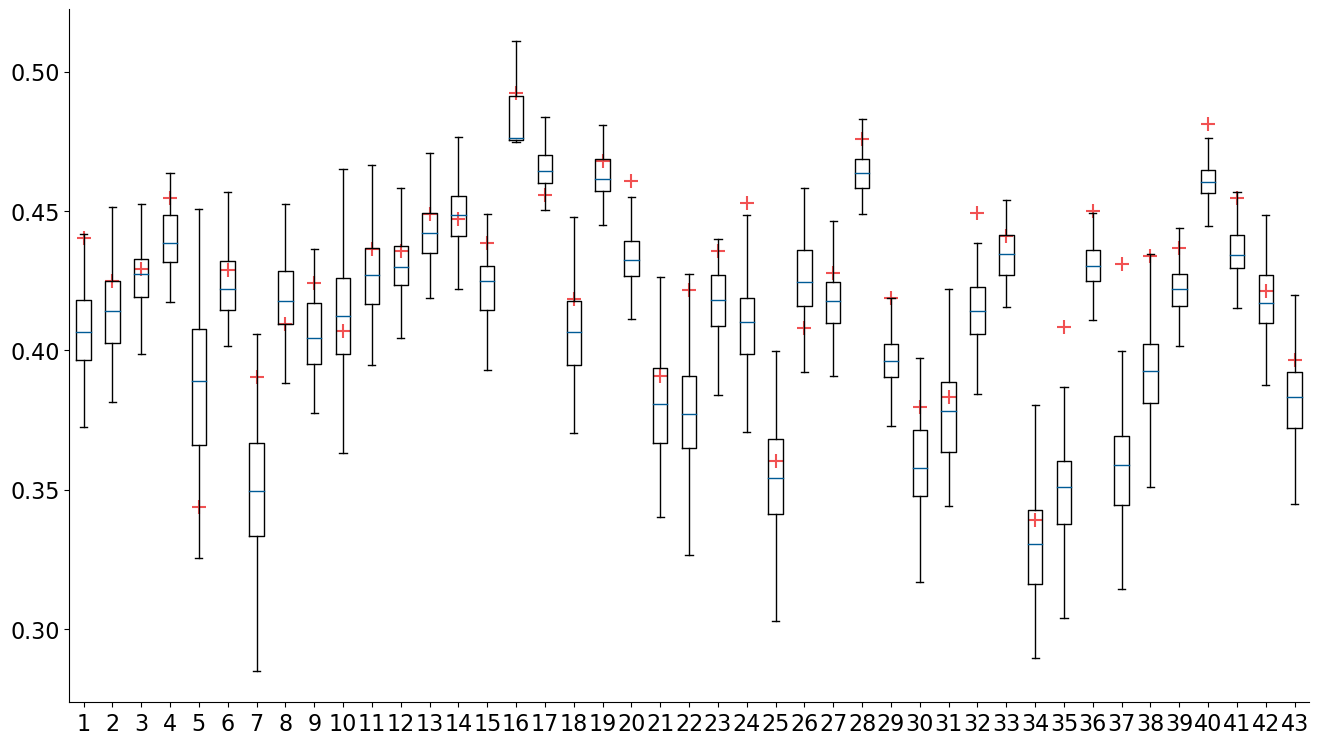

In [162]:
# Plot results

fig, ax = plt.subplots(figsize=(16, 9))
# boxplot plot for the benchmarks. Make the median line red
bp = ax.boxplot(
    assortativity_random.T,
    positions=np.arange(len(graphs)) + 1,
    showfliers=False,
)
# Scatter plot of assortativity
ax.scatter(
    np.arange(len(graphs)) + 1,
    s=100,
    marker="+",
)
plt.show()






In [1]:
"""
    5. BSS targeted villages leaders as seed nodes for their diffusion process. Is this a good strategy?
    Simulate the diffusion process using the BSS seed nodes and compare it with a random seed nodes strategy.
    Can you identify better seed nodes?

    You can use the function below to simulate the diffusion process.
"""

qN = 0.05
qP = 0.35


def diffusion_InformationModel(village_num, qN, qP, A, seeds, T, leadapt=leadapt):
    """
    Diffusion information model with endorsement. Simpler version of the model in the paper.
    qN: probability of non-infected to transmit the innovation
    qP: probability of infected to transmit the innovation
    A: adjacency matrix
    leaders: boolean array with leaders
    T: number of periods
    """
    N = A.shape[0]  # Number of individuals.
    
    infected = np.zeros(N, dtype=bool)  # Nobody has been infected yet.
    infectedbefore = np.zeros(N, dtype=bool)  # Nobody has been infected yet.
    contagiousbefore = np.zeros(N, dtype=bool)  # People who were contagious before
    contagious = np.array(seeds).astype(bool)  # Newly informed/contagious.
    dynamicInfection = []  # Will be a vector that tracks the infection rate for the number of periods it takes place

    contagious_at_t = np.zeros((T, N), dtype=bool)
    infected_at_t = np.zeros((T, N), dtype=bool)
    
    p = leadapt.loc[leadapt.village == village_num, "adopter"].mean()
    beta = np.log(p / (1 - p))
    
    for t in range(T):

        contagious_at_t[t, :] = contagious.copy()
        infected_at_t[t, :] = infected.copy()

        # Step 1: Take-up decision based on Newly informed, p. 
        LOGITprob = 1. / (1 + np.exp(-beta))
        infected = ((~contagiousbefore & contagious & (np.random.rand(N) < LOGITprob)) | infected)
        infectedbefore = (infectedbefore | infected)
        contagiousbefore = (contagious | contagiousbefore)
        
        # Step 2: Information flows
        transmitPROB = (contagious & infected)*qP + (contagious & ~infected)*qN  # Probability of transmission: Pr(.|infected)==qN, Pr(.|~infected)==qP. Individual (node) specific.
        contagionlikelihood = transmitPROB.reshape(-1, 1)*A
        newcontagious = ((contagionlikelihood > (1. -np.random.random(size=contagionlikelihood.shape))).astype(bool)).any(axis=0)
        
        # Step 3:
        contagious = newcontagious | contagiousbefore
        dynamicInfection.append(np.sum(infectedbefore)/N)
    
    return contagious_at_t, infected_at_t